# **This is an implementation of Wasserstein GANs with gradient penalty.**
## **Link to the paper is : https://arxiv.org/pdf/1704.00028.pdf**

Wasserstein GANs suggest a change in the distance function calculated while training any Generative Adverserial Network.
Earth mover's distance is a weaker distance and in their paper,. 
The other distances like Total Variance, KL Divergence and JS Divergence failed in the case of low dimensional manifolds where the distributions may have very little common projection space.
The mathematical details of the advantages of this distance can be read here : https://arxiv.org/pdf/1701.07875.pdf


We can even use Resnet-101 as a generator in WGAN-GP but let's keep it simple and train it on a DC GAN architecture 
Go on to my repository https://github.com/spandan2/Wgan-GP_cats for an implementation with tensorboard support

In [1]:
## clear the output

import os
import shutil

# Path to the working directory
working_dir = '/kaggle/working'

# Remove all files and directories within the working directory
for filename in os.listdir(working_dir):
    file_path = os.path.join(working_dir, filename)
    if os.path.isfile(file_path) or os.path.islink(file_path):
        os.remove(file_path)
    elif os.path.isdir(file_path):
        shutil.rmtree(file_path)

print("All files and directories in '/kaggle/working' have been deleted.")

All files and directories in '/kaggle/working' have been deleted.


In [2]:
##virtual env

# !pip install virtualenv
# !mkdir myenv
# !cd myenv

# !virtualenv venv

# !source venv/bin/activate


# !pip install virtualenv
# !python -m venv venv
# !cd /kaggle/working/venv
# !ls -ll
# !cd venv
# !pwd
# !mkdir /kaggle/working/venv
# !cd /kaggle/working/venv
# !ls -ll

# !/kaggle/working/venv/bin/python -m pip install --upgrade pip # just to be safe
# !/kaggle/working/venv/bin/pip install request # example
# !/kaggle/working/venv/bin/pip list



In [3]:
## MLFLow

!pip install --upgrade pip
# Install the requiered packages to run MLFlow

# !pip install --ignore-installed PyYAML


!pip install mlflow --quiet
!pip install pyngrok --quiet



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.5 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 23.3.2
    Uninstalling pip-23.3.2:
      Successfully uninstalled pip-23.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 24.6.1 requires cubinlinker, which is not installed.
cudf 24.6.1 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.6.1 requires ptxcompiler, which is not installed.
cuml 24.6.1 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 24.6.1 requires cupy-cuda11x>=12.0.0, which is not installed.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.4 which is incompatible.


In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
# print(os.listdir("/kaggle/input/cats-faces-64x64-for-generative-models/cats"))
os.chdir('..')
# Any results you write to the current directory are saved as output.

Let's import our dependencies

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
from torch.autograd import grad
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
import shutil
import statistics as st
import matplotlib.image as mpimg
import pylab

%pylab inline
pylab.rcParams['figure.figsize'] = (10, 10)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.10/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['pylab']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [6]:
import mlflow
import mlflow.pytorch

In [7]:
# !pip install --upgrade pytorch_lightning



> While defining the architecture of discriminators and Generators, we found that instead of rewriting blocks we can use functions to define blocks with much less repitition of code

In [8]:
import torch
print(torch.__version__)
# !pip install torch --upgrade



2.1.2


In [9]:
get_ipython().system_raw("mlflow ui --port 5000 &")
mlflow.pytorch.autolog()

2024-08-22 07:14:42.915874: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-22 07:14:42.915990: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-22 07:14:43.045852: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
[2024-08-22 07:14:44 +0000] [117] [INFO] Starting gunicorn 22.0.0
[2024-08-22 07:14:44 +0000] [117] [INFO] Listening at: http://127.0.0.1:5000 (117)
[2024-08-22 07:14:44 +0000] [117] [INFO] Using worker: sync
[2024-08-22 07:14:44 +0000] [118] [INFO] Booting worker with pid: 118
[2024-08-22 07:14:44 +0000] [119] [INFO] Booting worker with pid: 119
[2024-08-22 07:1

## Setting up MLFLow UI

In [10]:
# IMP: please create a auth token from https://dashboard.ngrok.com/auth by creating an account. 
# the below auth ticket will not work for anyone re-running the notebook.
    
from pyngrok import ngrok
from getpass import getpass

# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth

## ngrok account on shishir.sinha.ds@gmail.com

NGROK_AUTH_TOKEN = "2kcNs7F4szBzwTSYALiQwqmG4aC_2GxZcNZeaxLeAhhPSAted"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

MLflow Tracking UI: https://990b-35-226-14-215.ngrok-free.app                                       


In [11]:

class generator(nn.Module):
    def __init__(self, dim_in, dim=64):
        super(generator, self).__init__()

        def genblock(dim_in, dim_out):
            block = nn.Sequential(
                nn.ConvTranspose2d(in_channels=dim_in, 
                                   out_channels=dim_out,
                                   kernel_size=4, 
                                   stride=2, 
                                   padding=1,
                                   bias=False),
                nn.BatchNorm2d(dim_out),
                nn.ReLU()
            )
            return block

        def genimg(dim_in):
            block = nn.Sequential(
                nn.ConvTranspose2d(in_channels=dim_in, 
                                   out_channels=1,
                                   kernel_size=4, 
                                   stride=2, 
                                   padding=1,
                                   bias=False),
                nn.Tanh()
            )
            return block
        
        self.prepare = nn.Sequential(
            nn.Linear(dim_in, dim*16*8*8, bias=False),
            nn.BatchNorm1d(dim*16*8*8),
            nn.ReLU()
        )
        
        self.generate = nn.Sequential(
            genblock(dim*16, dim*8),
            genblock(dim*8, dim*4),
            genblock(dim*4, dim*2),
            genblock(dim*2, dim),
            genimg(dim)
        )

    def forward(self, x):
        x = self.prepare(x)
        x = x.view(x.size(0), -1, 8, 8)  # Adjusted for the new dimensions
        x = self.generate(x)
        return x

    
    
#%%
class critic(nn.Module):
    def __init__(self, dim_in, dim=64):
        super(critic, self).__init__()
        
        def critic_block(dim_in , dim_out):
            block = nn.Sequential(nn.Conv2d(in_channels = dim_in, 
                                            out_channels = dim_out,
                                            kernel_size = 5, 
                                            stride=2, 
                                            padding=2),
                                    nn.InstanceNorm2d(dim_out, affine= True),
                                    nn.LeakyReLU(0.2))
            return block
        self.analyze = nn.Sequential(nn.Conv2d(in_channels = dim_in, 
                                               out_channels = dim,
                                               kernel_size = 5, 
                                               stride=2, 
                                               padding=2),
                                     nn.LeakyReLU(0.2),
                                     critic_block(dim,dim*2),
                                     critic_block(dim*2,dim*4),
                                     critic_block(dim*4, dim*8),
                                     nn.Conv2d(in_channels=dim*8, 
                                               out_channels=1,
                                               kernel_size=4))
    def forward(self,x):
        x = self.analyze(x)
        x =x.view(-1)
        return x

In [12]:
def gradient_penalty(x,y,f):
    shape =[x.size(0)] + [1] * (x.dim() -1)
    alpha = torch.rand(shape).cuda()
    z = x+ alpha *(y-x)
    z = Variable(z,requires_grad=True)
    z=z.cuda()
    o=f(z)
    g = grad(o,z, grad_outputs=torch.ones(o.size()).cuda(), create_graph=True)[0].view(z.size(0), -1)
    gp = ((g.norm(p=2,dim=1))**2).mean()
    return gp
#%%
def save_checkpoint(state, save_path, is_best=False, max_keep=None):
    # save checkpoint
    torch.save(state, save_path)

    # deal with max_keep
    save_dir = os.path.dirname(save_path)
    list_path = os.path.join(save_dir, 'latest_checkpoint')

    save_path = os.path.basename(save_path)
    if os.path.exists(list_path):
        with open(list_path) as f:
            ckpt_list = f.readlines()
            ckpt_list = [save_path + '\n'] + ckpt_list
    else:
        ckpt_list = [save_path + '\n']

    if max_keep is not None:
        for ckpt in ckpt_list[max_keep:]:
            ckpt = os.path.join(save_dir, ckpt[:-1])
            if os.path.exists(ckpt):
                os.remove(ckpt)
        ckpt_list[max_keep:] = []

    with open(list_path, 'w') as f:
        f.writelines(ckpt_list)

    # copy best
    if is_best:
        shutil.copyfile(save_path, os.path.join(save_dir, 'best_model.ckpt'))
#%%
def load_checkpoint(ckpt_dir_or_file, map_location=None, load_best=False):
    if os.path.isdir(ckpt_dir_or_file):
        if load_best:
            ckpt_path = os.path.join(ckpt_dir_or_file, 'best_model.ckpt')
        else:
            with open(os.path.join(ckpt_dir_or_file, 'latest_checkpoint')) as f:
                ckpt_path = os.path.join(ckpt_dir_or_file, f.readline()[:-1])
    else:
        ckpt_path = ckpt_dir_or_file
    ckpt = torch.load(ckpt_path, map_location=map_location)
    print(' [*] Loading checkpoint from %s succeed!' % ckpt_path)
    return ckpt

**As mentioned in the paper, WGANs require a Lipschitz condition which on a high level can be understood as clipping the weights to a certain limit.
WGAN-GP enforces this Lipschitz condition not by clipping weights but by using a gradient penalty that is learnable unlike a hardcoded clipping.**


Other utilities have been defined for checkpointing and for saving images

In [13]:
import torch
import torchvision.utils as vutils
import os
from PIL import Image
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
import mlflow

# Set up MLflow experiment
mlflow.set_experiment("wgan_gp_experiment-Chest XRay")

# Start an MLflow run
with mlflow.start_run():

    epochs = 400
    batch_size = 8
    n_critic = 10
    lr = 0.0002
    z_dim = 100

    class CustomImageDataset(Dataset):
        def __init__(self, root_dir, transform=None):
            self.root_dir = root_dir
            self.transform = transform
            self.image_files = []
            self.labels = []

            # Traverse subdirectories and collect image paths and labels
            for label, sub_dir in enumerate(['PNEUMONIA', 'NORMAL']):
                sub_dir_path = os.path.join(root_dir, sub_dir)
                for file_name in os.listdir(sub_dir_path):
                    file_path = os.path.join(sub_dir_path, file_name)
                    if self.is_image(file_path):
                        self.image_files.append(file_path)
                        self.labels.append(label)

            if not self.image_files:
                raise ValueError(f"No images found in {root_dir}")

        def __len__(self):
            return len(self.image_files)

        def __getitem__(self, idx):
            img_path = self.image_files[idx]
            try:
                image = Image.open(img_path)
            except (IOError, UnidentifiedImageError) as e:
                print(f"Warning: Skipping {img_path} due to error: {e}")
                return self.__getitem__((idx + 1) % len(self))
            if self.transform:
                image = self.transform(image)
            label = self.labels[idx]
            return image, label

        def is_image(self, file_path):
            try:
                img = Image.open(file_path)
                img.verify()
                return True
            except (IOError, SyntaxError):
                return False

    # Transform
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Grayscale(num_output_channels=1),
        transforms.Normalize([0.5], [0.5])
    ])
    
    dataset = CustomImageDataset('/kaggle/input/chest-xray-pneumonia/chest_xray/train', transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=3)

    # Initialize models
    C = critic(1, 64)
    G = generator(z_dim, 64)
    
    # Wrap models in DataParallel
    if torch.cuda.device_count() > 1:
        C = torch.nn.DataParallel(C)
        G = torch.nn.DataParallel(G)

    C = C.cuda()
    G = G.cuda()

    G_opt = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
    C_opt = torch.optim.Adam(C.parameters(), lr=0.0001, betas=(0.5, 0.999))

    checkpoint = '/kaggle/input/chest-x-ray-epoch-305_wgan-gp/pytorch/default/1/Epoch_305.ckpt'
    save_dir = '/kaggle/working/sample_images/wgan_gp'
    if not os.path.exists(checkpoint):
        os.makedirs(checkpoint)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    try:
        ckpt = load_checkpoint(checkpoint)
        start_epoch = ckpt['epoch']
        C.load_state_dict(ckpt['D'])
        G.load_state_dict(ckpt['G'])
        C_opt.load_state_dict(ckpt['d_optimizer'])
        G_opt.load_state_dict(ckpt['g_optimizer'])
    except:
        print(' [*] No checkpoint!')
        start_epoch = 0
    
    z_sample = torch.randn(100, z_dim).cuda()
    
    # Log hyperparameters
    mlflow.log_param("epochs", epochs)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("learning_rate", lr)
    mlflow.log_param("z_dim", z_dim)
    
    # Training loop
    for epoch in range(start_epoch, epochs):
        start_time = time.time()
        C_loss = []
        G_loss = []
        G.train()
        for i, (images, _) in enumerate(dataloader):
            step = epoch * len(dataloader) + i + 1
            images = images.cuda()
            batch = images.size(0)
            z = torch.randn(batch, z_dim).cuda()

            generated = G(z)
            real_criticized = C(images)
            fake_criticized = C(generated)

            em_distance = real_criticized.mean() - fake_criticized.mean()
            grad_penalty = gradient_penalty(images.data, generated.data, C)

            CriticLoss = -em_distance + grad_penalty * 10
            C_loss.append(CriticLoss.item())
            C_opt.zero_grad()
            CriticLoss.backward()
            C_opt.step()

            if step % n_critic == 0:
                z = torch.randn(batch, z_dim).cuda()
                generated = G(z)
                fake_criticized = C(generated)
                GenLoss = -fake_criticized.mean()
                G_loss.append(GenLoss.item())
                G_opt.zero_grad()
                GenLoss.backward()
                G_opt.step()
                print(f"Epoch {epoch+1}: {i+1}/{len(dataloader)} :: {(time.time()-start_time)/60:.2f} mins", end='\r')

        # Log losses for this epoch
        mlflow.log_metric("CriticLoss", sum(C_loss)/len(C_loss), step=epoch)
        mlflow.log_metric("GeneratorLoss", sum(G_loss)/len(G_loss), step=epoch)
        
        print("CriticLoss", sum(C_loss)/len(C_loss))
        print("GeneratorLoss", sum(G_loss)/len(G_loss))
        print(f"Epoch {epoch+1} completed")

        # Generate and log sample images
        G.eval()
        with torch.no_grad():
            fake_gen_images = (G(z_sample).data + 1) / 2.0
            image_path = f"{save_dir}/Epoch_{epoch+1}.jpg"
            vutils.save_image(fake_gen_images, image_path, nrow=10)
            mlflow.log_artifact(image_path)

        # Save and log checkpoint every 5 epochs
        if (epoch + 1) % 5 == 0:
            checkpoint_path = f'/kaggle/working/Epoch_{epoch + 1}.ckpt'
            torch.save({
                'epoch': epoch + 1,
                'D': C.state_dict(),
                'G': G.state_dict(),
                'd_optimizer': C_opt.state_dict(),
                'g_optimizer': G_opt.state_dict()
            }, checkpoint_path)
            mlflow.log_artifact(checkpoint_path)


2024/08/22 07:14:55 INFO mlflow.tracking.fluent: Experiment with name 'wgan_gp_experiment-Chest XRay' does not exist. Creating a new experiment.


 [*] Loading checkpoint from /kaggle/input/chest-x-ray-epoch-305_wgan-gp/pytorch/default/1/Epoch_305.ckpt succeed!


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


CriticLoss -0.00010164904525353355
GeneratorLoss 0.019238257793208154
Epoch 306 completed
CriticLoss -0.00010465601727262353
GeneratorLoss 0.02165592761996847
Epoch 307 completed
CriticLoss -0.00010030962520839104
GeneratorLoss 0.006250001109527567
Epoch 308 completed
CriticLoss -9.918690800518254e-05
GeneratorLoss 0.006746175991765295
Epoch 309 completed
CriticLoss -9.911473331782979e-05
GeneratorLoss 0.021548021796413443
Epoch 310 completed
CriticLoss -9.785133871038986e-05
GeneratorLoss 0.017935610806139615
Epoch 311 completed
CriticLoss -9.862788908985805e-05
GeneratorLoss 0.017086228527701818
Epoch 312 completed
CriticLoss -0.00010004018695661306
GeneratorLoss 0.007480123541888763
Epoch 313 completed
CriticLoss -9.760470839290154e-05
GeneratorLoss 0.0015983701276127249
Epoch 314 completed
CriticLoss -9.82022934155453e-05
GeneratorLoss 0.011424055360927896
Epoch 315 completed
CriticLoss -0.00010539926939388235
GeneratorLoss 0.0019369720756703128
Epoch 316 completed
CriticLoss -0.00

In [22]:
G_loss_new=[]

for g in G_loss:
    G_loss_new.extend([g]*10)
    
G_loss_new=G_loss_new[:len(C_loss)]

In [23]:
len(G_loss_new), len(C_loss)

(652, 652)

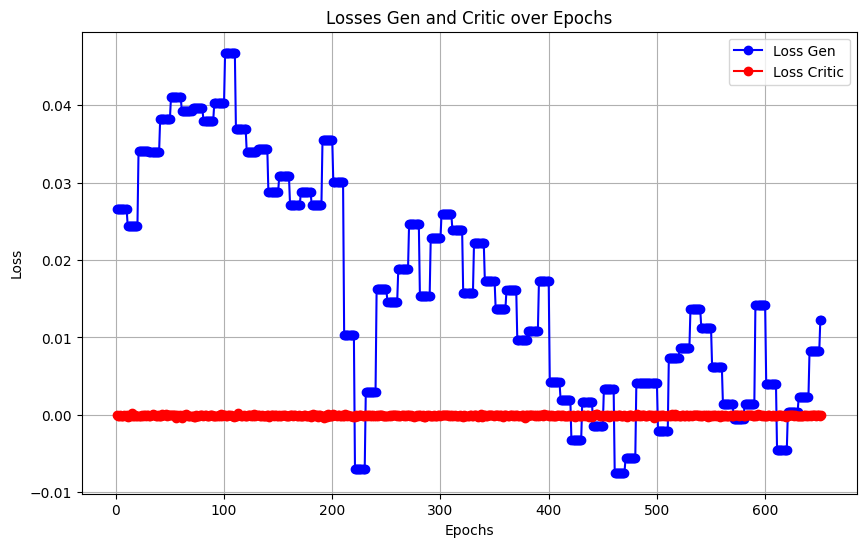

In [25]:
import matplotlib.pyplot as plt

epochs=list(range(1,653))

import matplotlib.pyplot as plt

# Sample data
A = G_loss_new  # Replace with your actual loss values for A
B = C_loss  # Replace with your actual loss values for B

# Create the plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Plot Loss A
plt.plot(epochs, A, label='Loss Gen', marker='o', color='blue')

# Plot Loss B
plt.plot(epochs, B, label='Loss Critic', marker='o', color='red')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Losses Gen and Critic over Epochs')

# Add a legend
plt.legend()

# Add grid for better readability
plt.grid(True)

# Show the plot
plt.show()


In [14]:
# Save generator model and optimizer state
torch.save({
    'epoch': epoch,  # Current epoch number
    'model_state_dict': G.state_dict(),  # Model's state dictionary
    'optimizer_state_dict': G_opt.state_dict()  # Optimizer's state dictionary
}, '/kaggle/working/generator_checkpoint_258.pth')

# Save critic model and optimizer state
torch.save({
    'epoch': epoch,  # Current epoch number
    'model_state_dict': C.state_dict(),  # Model's state dictionary
    'optimizer_state_dict': C_opt.state_dict()  # Optimizer's state dictionary
}, '/kaggle/working/critic_checkpoint_258.pth')

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim

z_dim = 100

# # Define the generator model
G1 = generator(z_dim)


# Define the optimizer for the generator (assuming SGD for example)
G_opt1 = optim.SGD(G1.parameters(), lr=0.001)

# Path to the checkpoint
checkpoint_path = '/kaggle/working/Epoch_400.ckpt'

# Load the checkpoint
checkpoint = torch.load(checkpoint_path)


# Load state dict into models
def remove_module_prefix(state_dict):
    """Remove the 'module.' prefix from state dict keys."""
    new_state_dict = {}
    for k, v in state_dict.items():
        new_key = k[7:] if k.startswith('module.') else k
        new_state_dict[new_key] = v
    return new_state_dict

# Remove 'module.' prefix if present
C_state_dict = remove_module_prefix(checkpoint['D'])
G_state_dict = remove_module_prefix(checkpoint['G'])


G1.load_state_dict(G_state_dict)

G1.cuda()
# # Now G and G_opt are loaded and ready to be used for inference or further training



# ######################

# # C = critic(3)


# # # Define the optimizer for the generator (assuming SGD for example)
# # C_opt = optim.SGD(G.parameters(), lr=0.001)

# # # Load the checkpoint
# # checkpoint_path = '/kaggle/input/wgan-gp-250-epochs/pytorch/default/1/critic_checkpoint_250.pth'
# # checkpoint = torch.load(checkpoint_path)

# # # Load model's state_dict
# # C.load_state_dict(checkpoint['model_state_dict'])

# # # Load optimizer's state_dict
# # # C_opt.load_state_dict(checkpoint['optimizer_state_dict'])

# # # Optional: Load other items saved in the checkpoint
# # epoch = checkpoint['epoch']

# # C.cuda()
# # # Now G and G_opt are loaded and ready to be used for inference or further training


generator(
  (prepare): Sequential(
    (0): Linear(in_features=100, out_features=65536, bias=False)
    (1): BatchNorm1d(65536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (generate): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): ConvTranspose2d(1

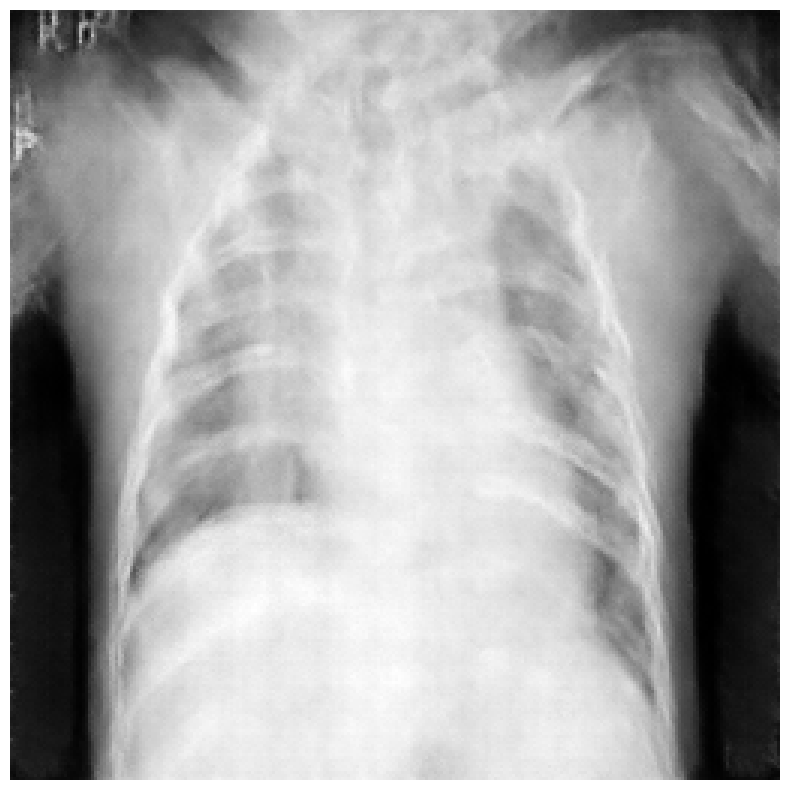

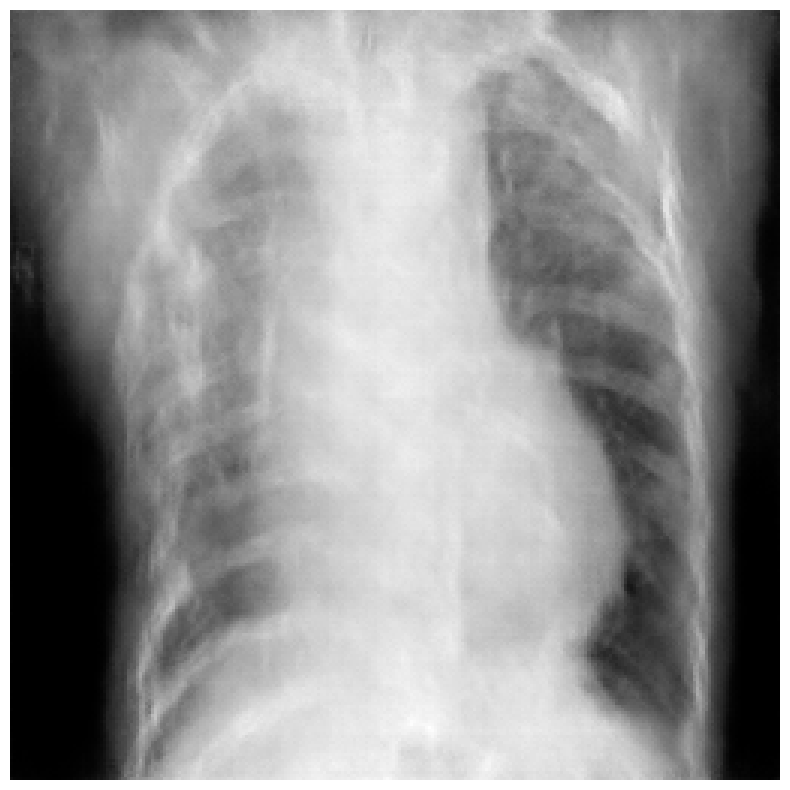

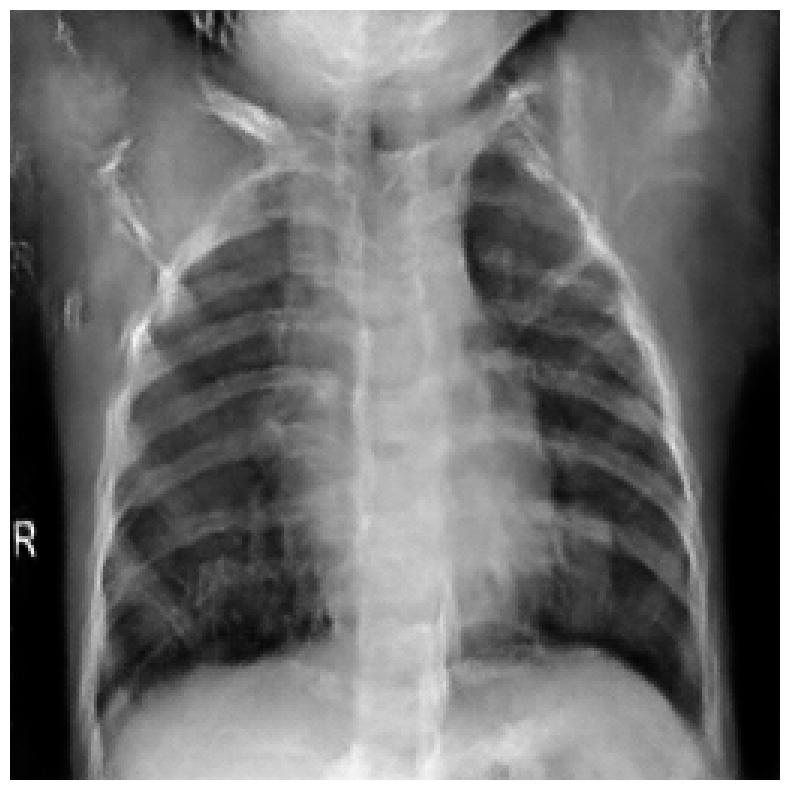

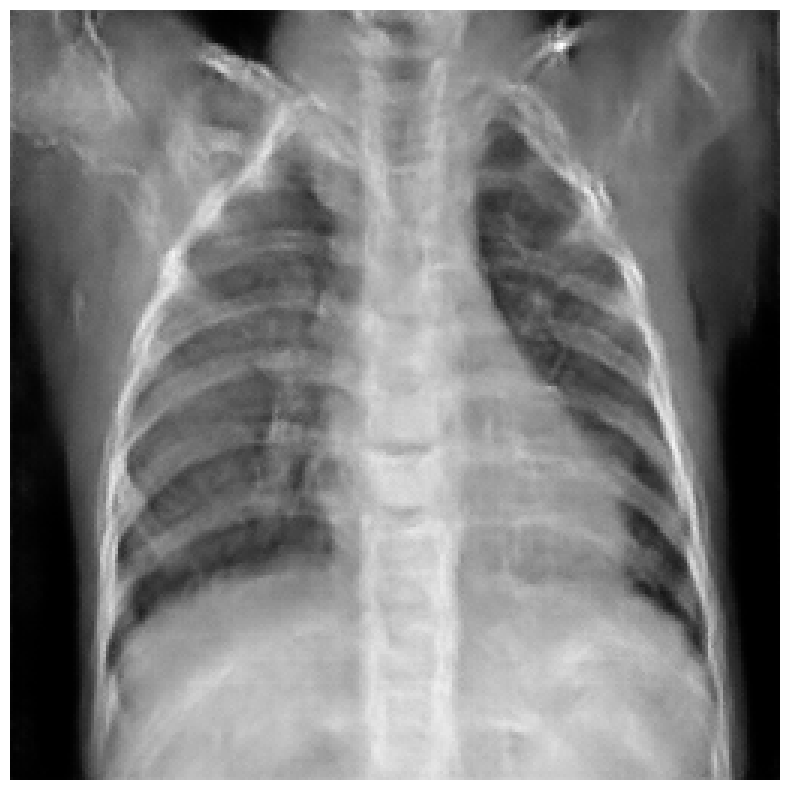

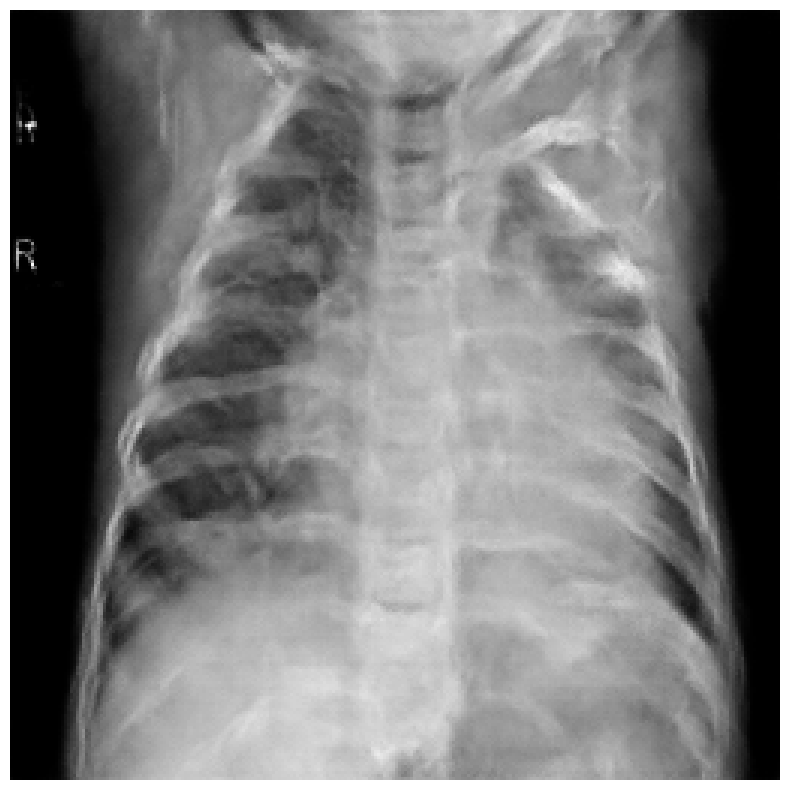

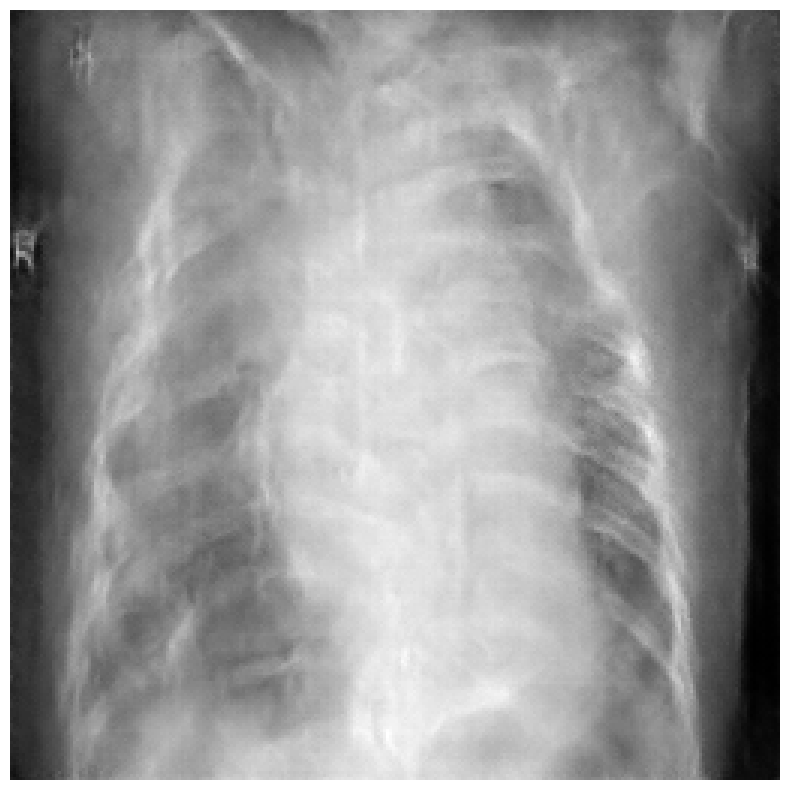

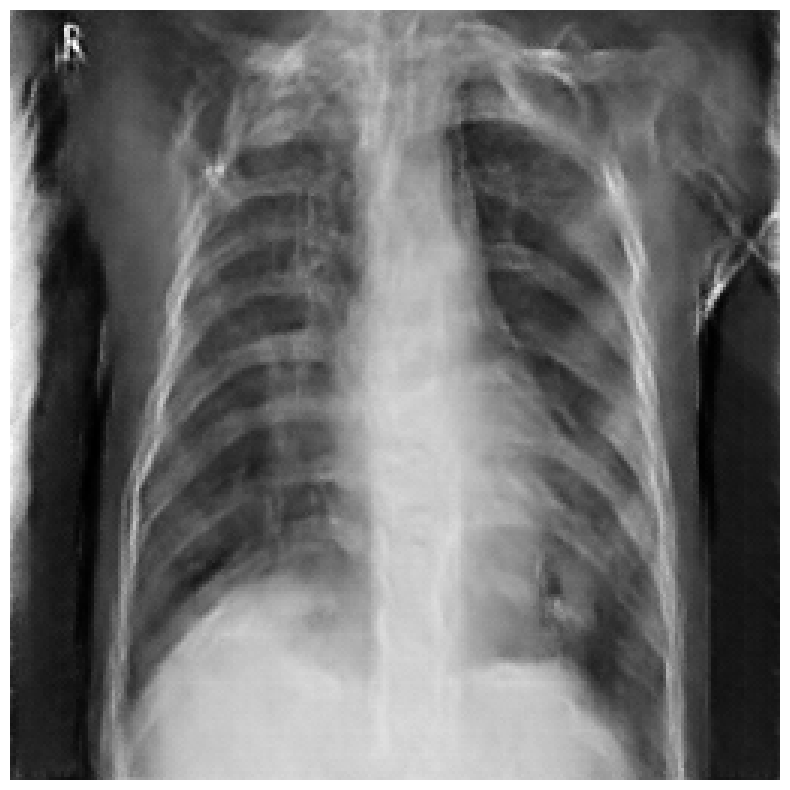

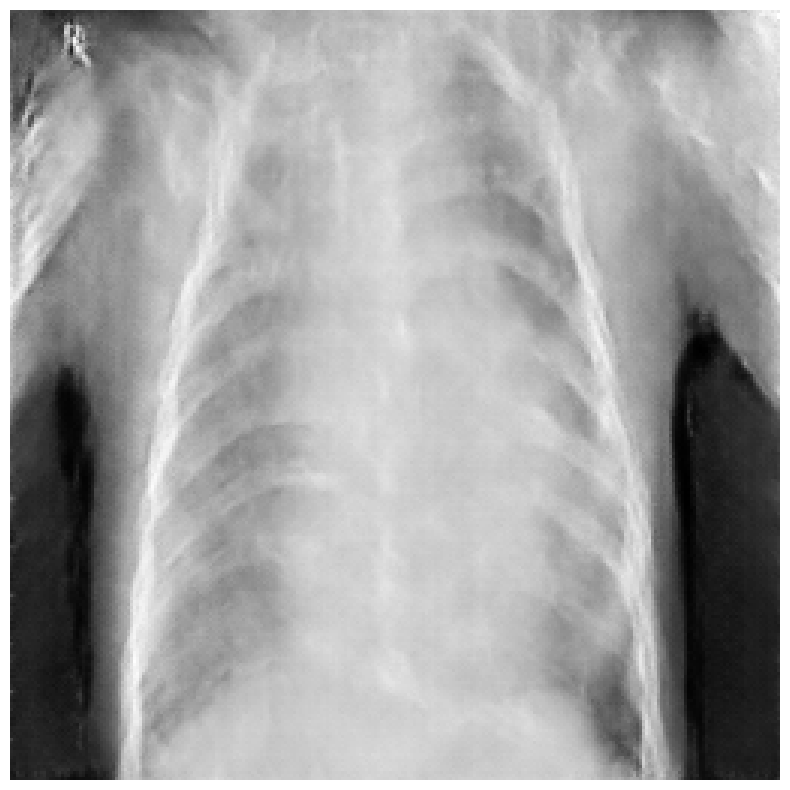

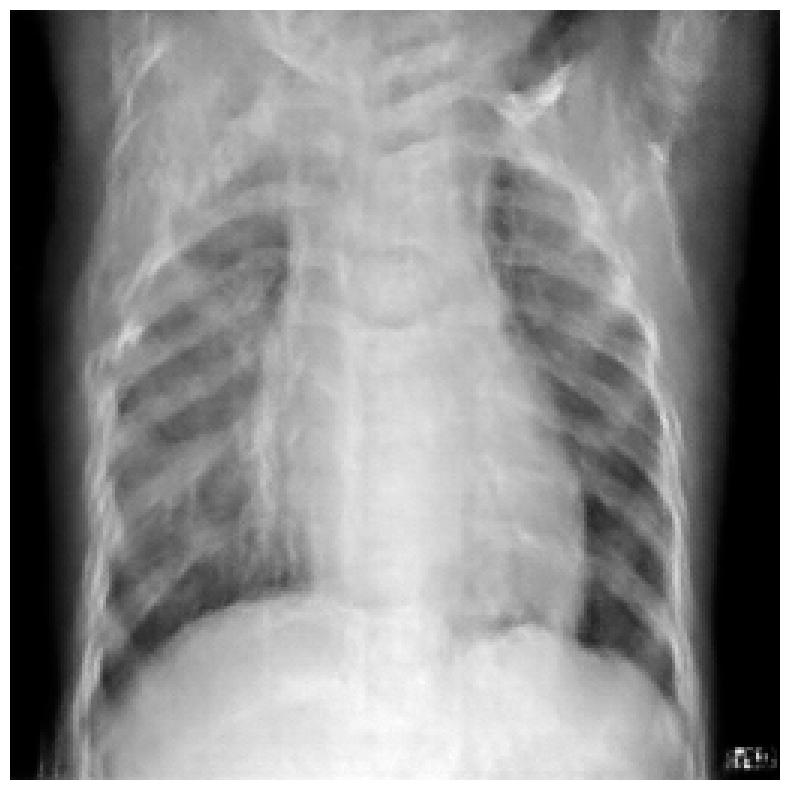

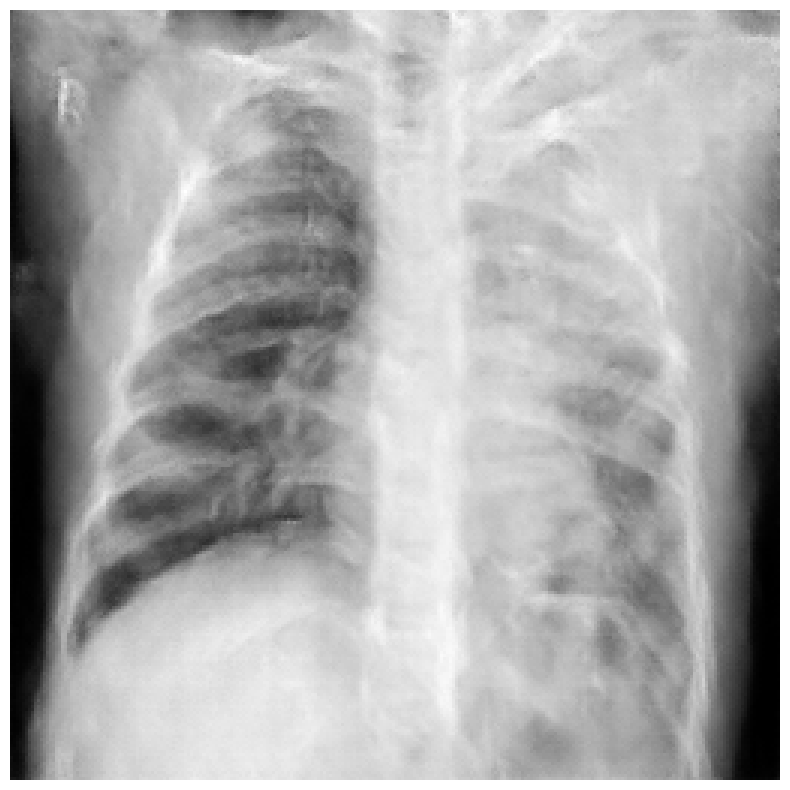

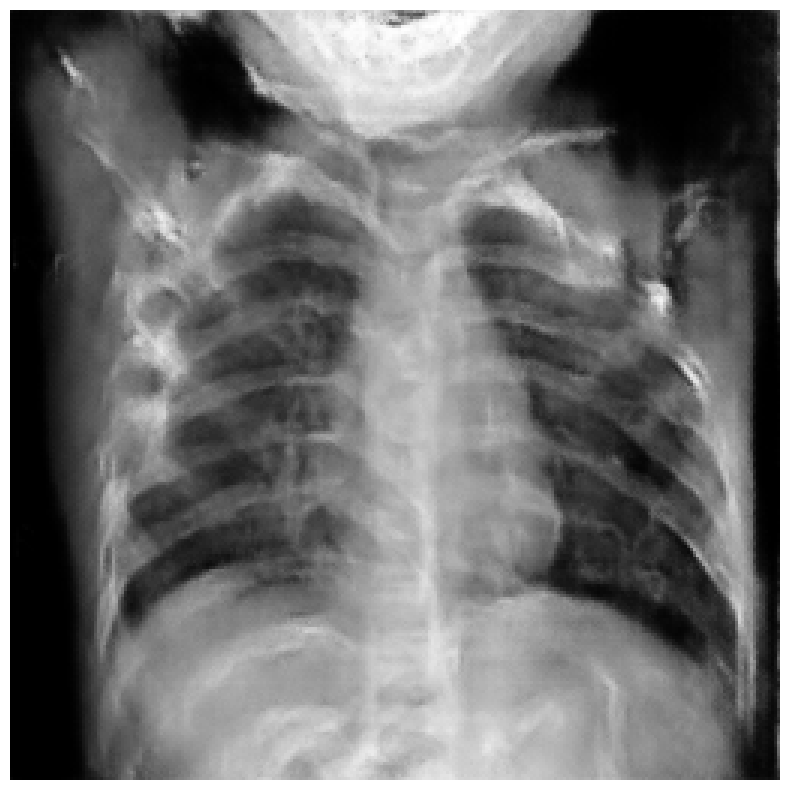

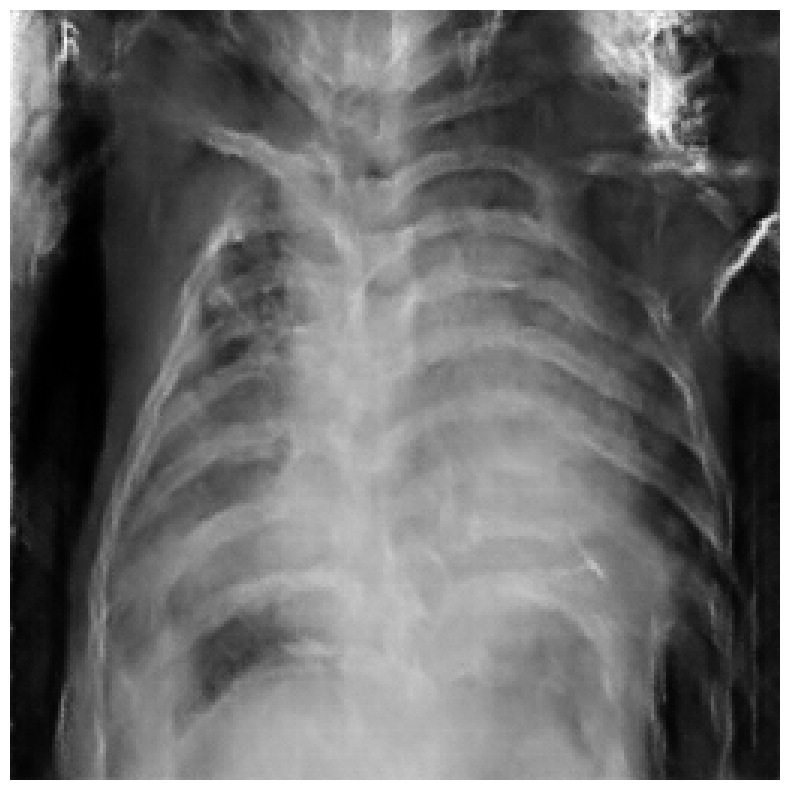

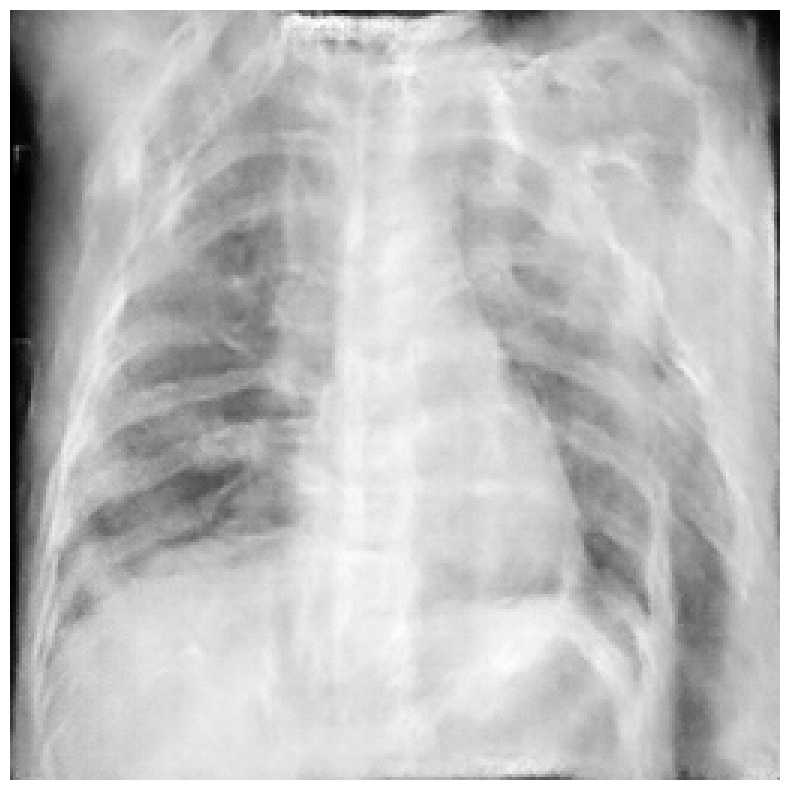

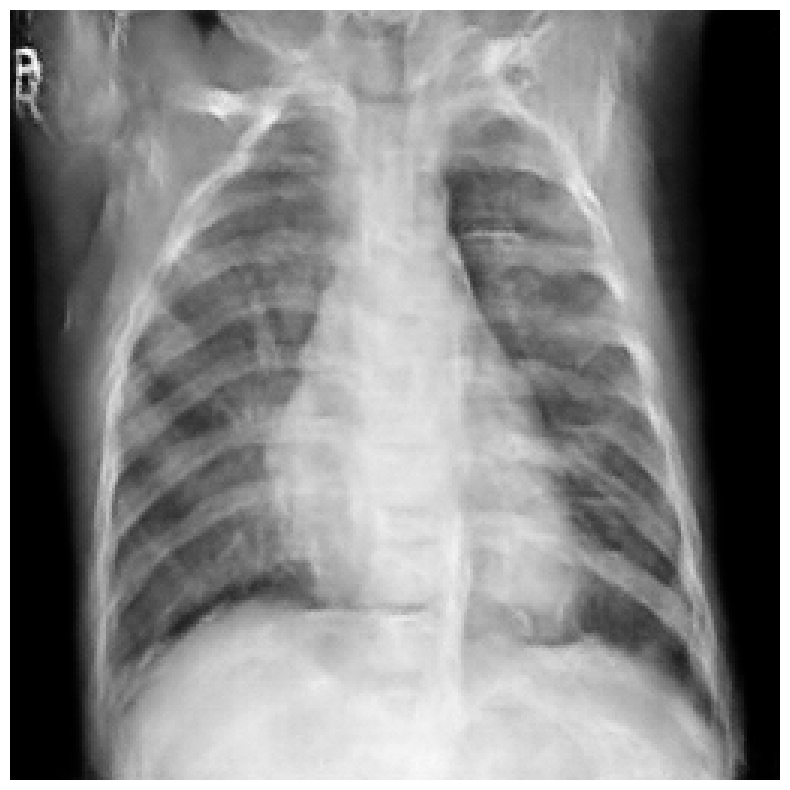

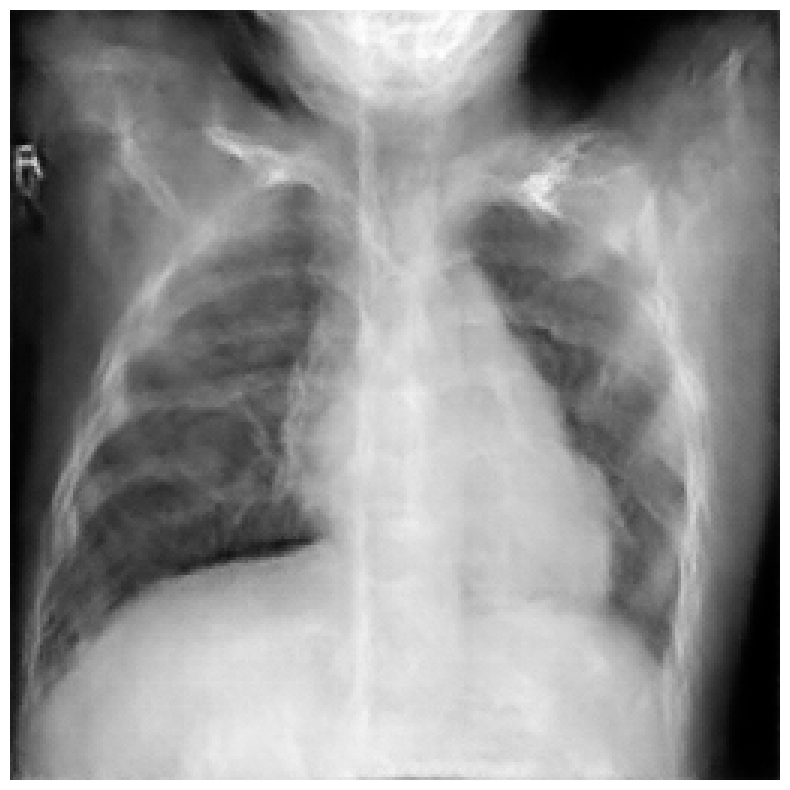

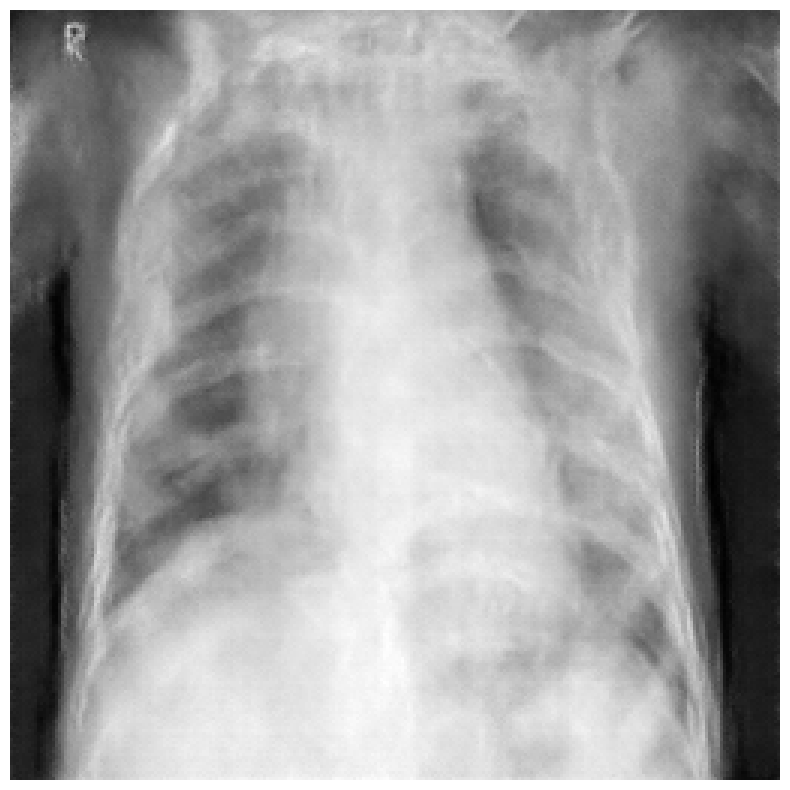

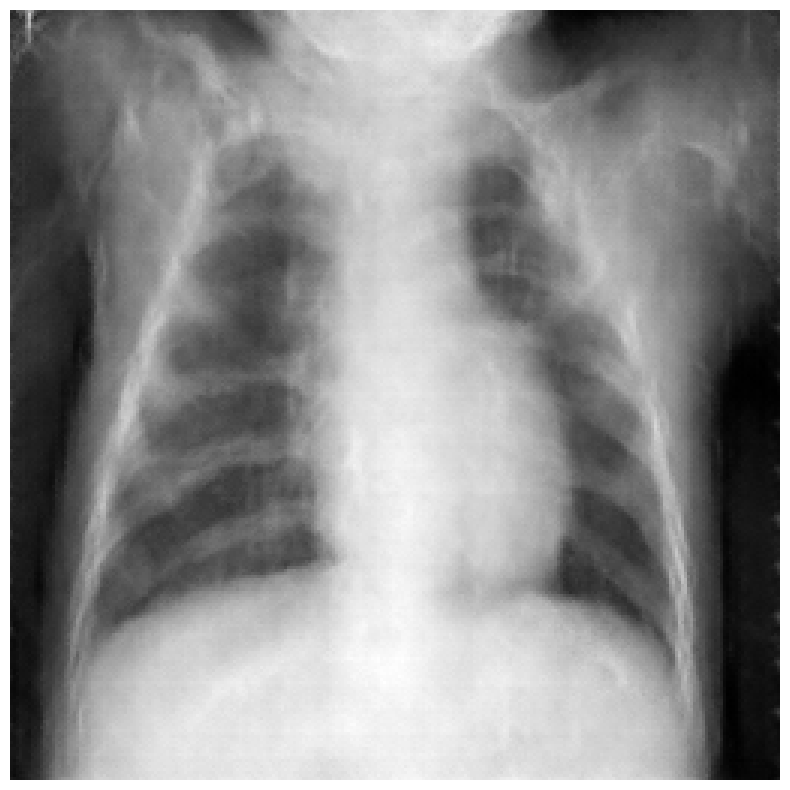

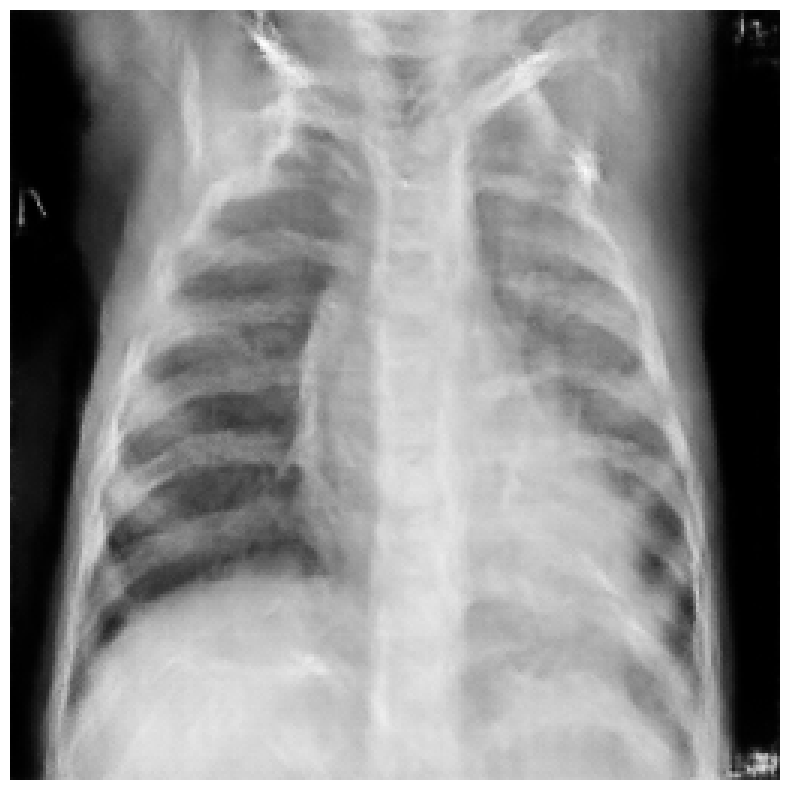

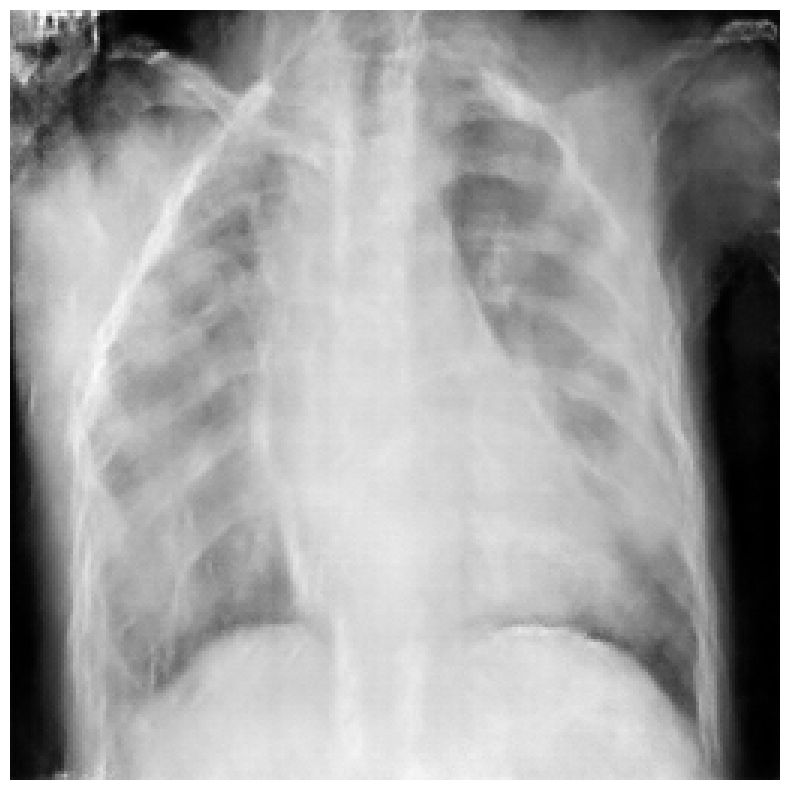

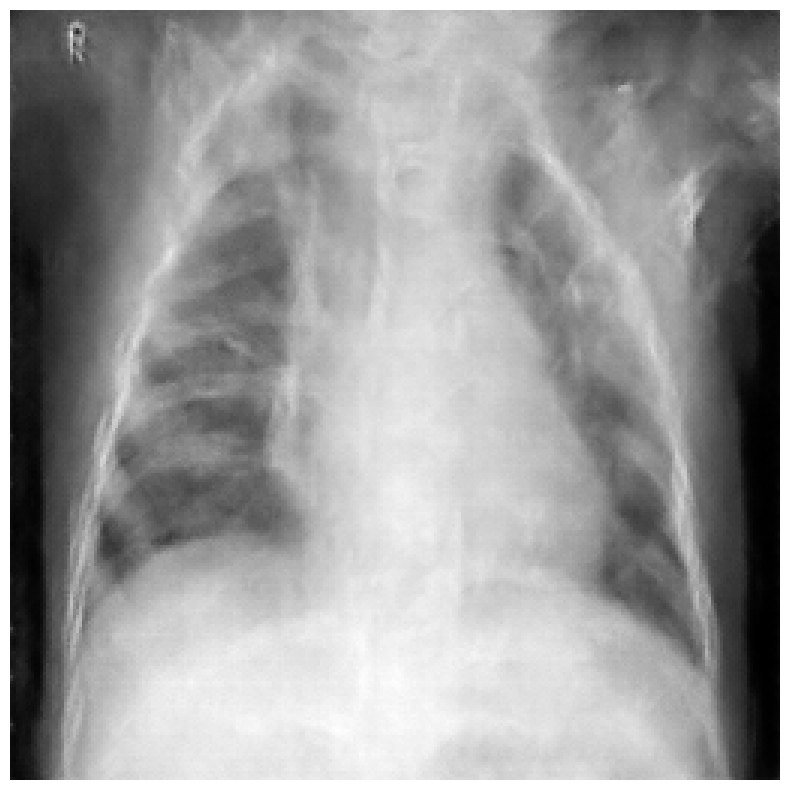

In [27]:
import torch
import torchvision
import matplotlib.pyplot as plt

# Generate 20 images
z_dim = 100  # Make sure z_dim matches your generator's input dimension
batch_size = 20
z = torch.randn(batch_size, z_dim).cuda()
out = G1(z)

# Convert the images to numpy arrays
out_images = out.detach().cpu().numpy()

# Convert from (C, H, W) to (H, W, C) for plotting
out_images = [img.transpose(1, 2, 0) for img in out_images]

# # Create a grid of images
# grid = torchvision.utils.make_grid(out, nrow=10)  # Arrange in 5 columns

# # Convert grid to numpy array for plotting
# grid_image = grid.permute(1, 2, 0).cpu().detach().numpy()

for fig in out_images:
    # Plot the grid
    plt.figure(figsize=(10, 10))
    plt.imshow(fig,cmap='gray')
    plt.axis('off')  # Hide axes
    plt.show()


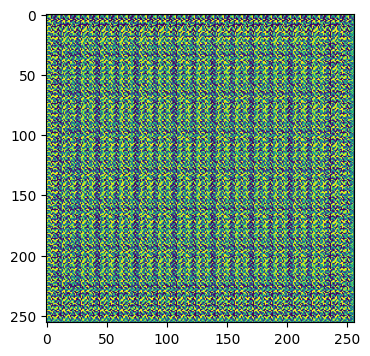

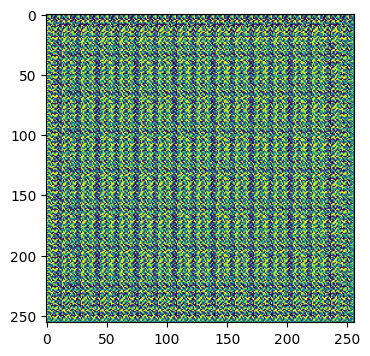

In [29]:
out_image0 = out[0].detach().cpu().numpy()
out_image1 = out[1].detach().cpu().numpy()


# Convert from (C, H, W) to (H, W, C) for plotting if necessary
out_image0 = out_image0.transpose(1, 2, 0)
out_image1 = out_image1.transpose(1, 2, 0)

plt.figure(figsize=(4, 4))# Plot the image
plt.imshow(out_image0)
plt.show()
plt.figure(figsize=(4, 4))# Plot the image

plt.imshow(out_image1)

plt.show()

In [ ]:
z = Variable(torch.randn(2, z_dim))
z = z.cuda()
out=G(z)
out.shape


out_image0 = out[0].detach().cpu().numpy()
out_image1 = out[1].detach().cpu().numpy()


# Convert from (C, H, W) to (H, W, C) for plotting if necessary
out_image0 = out_image0.transpose(1, 2, 0)
out_image1 = out_image1.transpose(1, 2, 0)

plt.figure(figsize=(4, 4))# Plot the image
plt.imshow(out_image0)
plt.show()
plt.figure(figsize=(4, 4))# Plot the image

plt.imshow(out_image1)

plt.show()

# **Outputs as trained in this notebook**

In [ ]:
a= os.listdir('sample_images/wgan_gp/')
a.sort()
print(a[-1])
img=mpimg.imread('sample_images/wgan_gp/'+a[-1])
plt.imshow(img)
plt.axis('off')
plt.show()

# Output after training for 500 epochs

In [ ]:
!wget https://raw.githubusercontent.com/spandan2/Wgan-GP_cats/master/sample_images/wgan_gp/Epoch%20500.jpg
img=mpimg.imread('Epoch 500.jpg')
plt.imshow(img)
plt.axis('off')
plt.show()